# Dataset Curation

Historical data for BSE Sensex is obtained from [Yahoo Finance](https://finance.yahoo.com/quote/%5EBSESN/history?period1=1420070400&period2=1660003200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true). 

We entered the start and end dates and copied the entries from the table element on the yahoo finance website and stored them as `yahoo_finance_bse_historical_table.html` file. We will now use beautiful-soup to parse the html table information into a pandas dataframe for subsequent analysis.


In [1]:
# !pip install -q beautifulsoup4 pandas numpy scikit-learn matplotlib seaborn statsmodels pmdarima

In [2]:
# Get all the libraries
import re
import warnings
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup

# warnings.filterwarnings("ignore")

plt.style.use("ggplot")
%matplotlib inline

In [3]:
html_doc = Path("yahoo_finance_bse_historical_table.html").read_text()
soup = BeautifulSoup(html_doc, "html.parser")

# Column Headers
columns = [x.text for x in soup.find("thead").find_all("span")]

# Read the table rows
table_body = soup.find("tbody")
table_rows = table_body.find_all("tr")

# Extract information from each and every individual row
empty_dates = []


def extract_info(row):
    elements = []
    for item in row.find_all("td"):
        if item.span:
            elements.append(item.span.text)
        # In some cases, we have instances of empty rows
        else:
            elements.append("-1")

    elements = [elements[0]] + [float(re.sub(",", "", x)) for x in elements[1:]]

    return elements


# Get all the rows and subsequently create a dataframe
# Invert the entries to go from earlier to later timeperiods
records = [extract_info(x) for x in table_rows][::-1][1:]

In [4]:
df = pd.DataFrame(records, columns=columns)
df = df[df.Open != -1].reset_index(drop=True)
df["Date"] = pd.to_datetime(df["Date"], infer_datetime_format=True)

# Remove special trading entries which happen on Saturday/sunday to maintian the
# Time Period Integrity of the dataset
df = df[df.Date.dt.weekday.apply(lambda x: x in [0, 1, 2, 3, 4])].reset_index(drop=True)

# Keep only the data till Jun 2021 as that's the range asked for in the question
df = df[df.Date < "07-04-2021"].reset_index(drop=True)
df.index = df["Date"]
df.tail(10)

,Date,Open,High,Low,Close*,Adj Close**,Volume
Date,,,,,,,
2021-06-21,2021-06-21,51887.55,52629.18,51740.19,52574.46,52574.46,12500.0
2021-06-22,2021-06-22,52885.04,53057.11,52520.55,52588.71,52588.71,7700.0
2021-06-23,2021-06-23,52912.35,52912.35,52264.12,52306.08,52306.08,13600.0
2021-06-24,2021-06-24,52514.57,52830.68,52385.05,52699.00,52699.00,7900.0
2021-06-25,2021-06-25,52877.16,52973.07,52614.49,52925.04,52925.04,10700.0
2021-06-28,2021-06-28,53126.73,53126.73,52673.50,52735.59,52735.59,6200.0
2021-06-29,2021-06-29,52795.76,52816.42,52477.77,52549.66,52549.66,9200.0
2021-06-30,2021-06-30,52651.09,52875.92,52448.64,52482.71,52482.71,9500.0
2021-07-01,2021-07-01,52638.50,52638.50,52281.01,52318.60,52318.60,5800.0


In [5]:
# Have a look at the holidays encountered in this period and fill them in the dataset.
# Make sure to add a flag telling whether this day is a holiday or not
idxs = []
offset = 0
for idx, entry in enumerate(df.Date.dt.weekday):
    if (idx + offset) % 5 != entry:
        offset += 1
        idxs.append(idx)

from pandas.tseries.offsets import BDay

(df.iloc[idxs, :].Date - BDay(1))[:3]

Date
2015-01-27   2015-01-26
2015-02-18   2015-02-17
2015-03-09   2015-03-06
Name: Date, dtype: datetime64[ns]

From the table above, we can see that there's some fixed holidays which recurringly occur over the course of years like `Republic Day, Mahashivratri, Holi, Good Friday, Eid etc.`.

We can add these to our dataset, use forwardfill to carry over the information from the previous day to the current day and add an indicator showing that this particular day was a holiday. This will ensure we have a contiguous chronological sequence with no gaps and also we'll use the holiday as an exogenuos variable to let the model know we're carrying forward this info as is to preserve the integrity of the dataset

In [6]:
# Create a business day daterange object starting from lowest to highest day
new_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="B")

# Use ffill i.e. fill the latest available value forward
reindexed_df = df.reindex(new_date_range, method="pad")

In [7]:
# Create a column which reflects if I have substituted a missing value for
# a holiday or not
missing_dates = set(reindexed_df.index) - set(df.index)
missing_indicator = (
    reindexed_df.index.map(lambda x: x in missing_dates) * 1.0
).tolist()
reindexed_df["Holiday"] = missing_indicator

In [8]:
df = reindexed_df

We have now collected data for `BSE Sensex` index right from the year `2015` upto the current day. However, we can truncate the dataset till `June 2021` since the problem statement expects us to only predict till that point in time.

We have the following columns in our dataset

- Date: The date corresponding to which the information is presented
- Open: What was the opening index amount
- High: What was the highest that the index touched for that day
- Low: What was the lowest that the index touched for that day
- Close: What was the closing index amount (Our Prediction Value)
- Volume: An indicator of the amount of trades happening within the given day
- Adj Close: Adjusted close price adjusted for splits/dividends and other capital gain distributions

# Task Definition

We have the information related to BSE Sensex Index from the second of January 2015 to date. We are wanting to predict the close price of the index everyday for the period `Apr' 21 to Jun'21` and using data before that time period to train our model.

The data is collected on a per day basis. Reasons for selecting the granularity as `1 day`:

- The output expects us to predict daily prices in the `April'21 - June'21` Range. So, it makes sense to have the train data at the same granularity as the test data.

- We could also fit an hourly/minutely model and then predict on the last hour/ last minute for the April'21 or June'21 period. However that would make the problem of fetching the data and subsequently processing it very complex. Hence, we chose to restrict ourselves to a per day frequency for this task.

## Modelling

We will model this problem as a time-series forecasting problem with `close` as the `label` or target variable.

Since we're modelling the problem as a time-series problem, we can only use

- Historical data about the index

- Exogenous Predictors: Variables which are predetermined and will still impact the index value in the future.

This means, we will not be able to make use of `Open`, `High`, `Low` and `Volume` factors in our analysis (at least for the SARIMAX model).

**Why?**

Because we're assuming we're standing on March 31, 2021 and looking to predict values for April through June 2021. This means no transactions have happened as yet and the values of these features are not yet known to us. We will need to create features that are exogenous.

We already have the date which is a really strong feature. We could extract

- DW: Day of the week
- MM: Month of the year
- QT: Quarter to which the day belongs

Decomposing the date into these three components and treating them as categorical exogenous variables is possible as these values are fixed in the future and there's no uncertainty in these features 

In [9]:
df["DOW"] = df.index.day_name()
df["MOY"] = df.index.month_name()
df["Q"] = df.index.quarter
df["Q"] = df.Q.apply(lambda x: str(x))
df.drop(columns=["Open", "High", "Low", "Adj Close**", "Volume"], inplace=True)

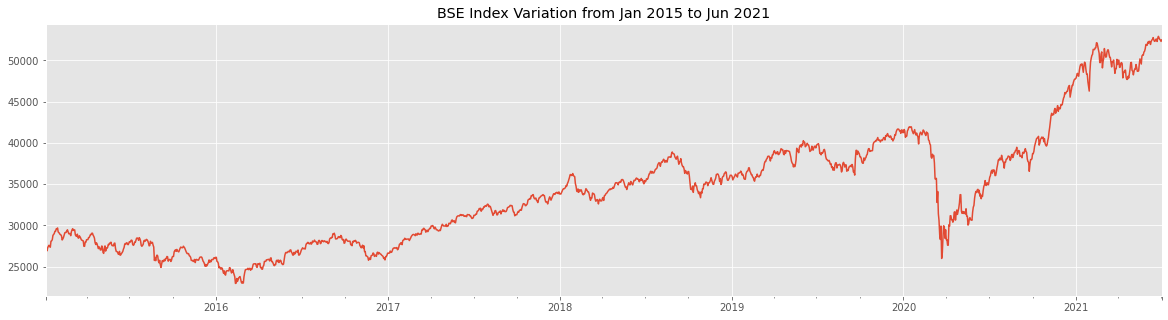

In [10]:
plt.figure(figsize=(20, 5))
df["Close*"].plot()
plt.title("BSE Index Variation from Jan 2015 to Jun 2021");

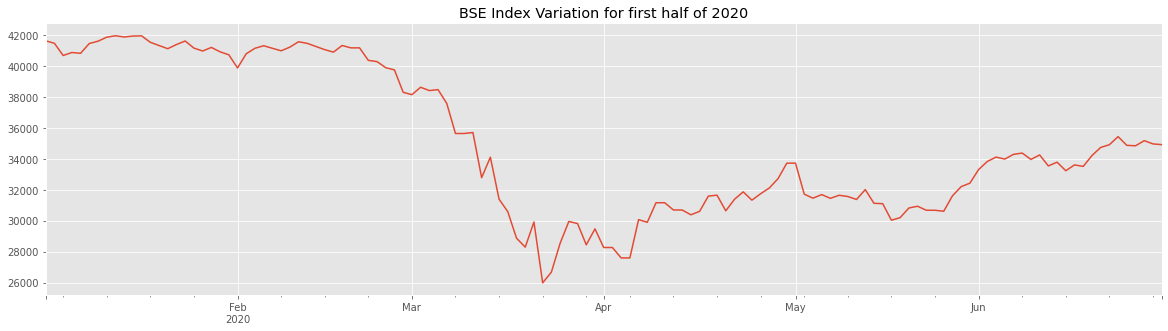

In [11]:
plt.figure(figsize=(20, 5))
df[(df.index > "01-01-2020") & (df.index < "07-01-2020")]["Close*"].plot()
plt.title("BSE Index Variation for first half of 2020");

We can see that the market has over and above continued to rise steadily over time. However there's a huge dip in the period spanning from `Jan 2020 - April 2020`. This is the time when COVID struck adversely and most of the industries and work had come to a standstill. 

Let us try and analyse the `Close` index a little more closely.

We shall decompose the Close index values and assume a seasonality of 5 since we have 5 working days every week.

In [12]:
# fig, ax = plt.subplots(1, 1, figsize = (20,15))
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df["Close*"])

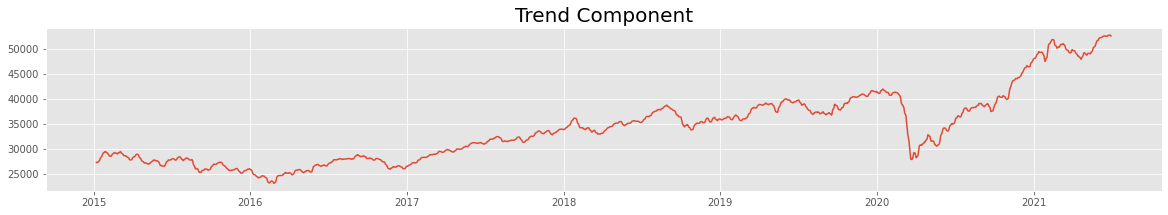

In [13]:
# Look at the trend part of the result
fig, ax = plt.subplots(1, 1, figsize=(20, 3))
plt.plot(df.index.tolist(), result.trend)
plt.title("Trend Component", fontsize=20);

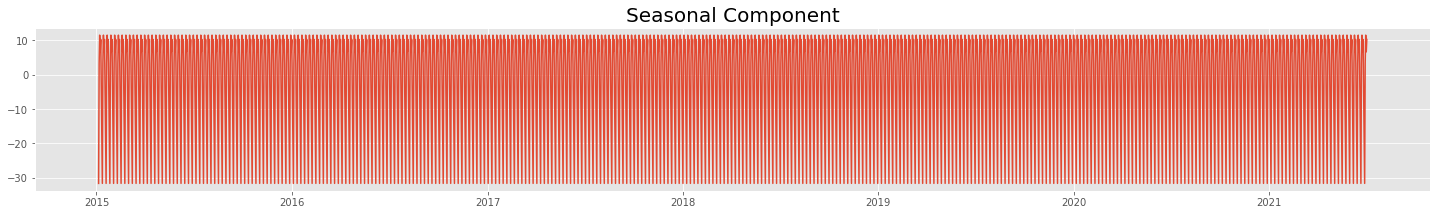

In [14]:
# Look at the seasonal part of the result
fig, ax = plt.subplots(1, 1, figsize=(25, 3))
plt.plot(df.index.tolist(), result.seasonal)
plt.title("Seasonal Component", fontsize=20);

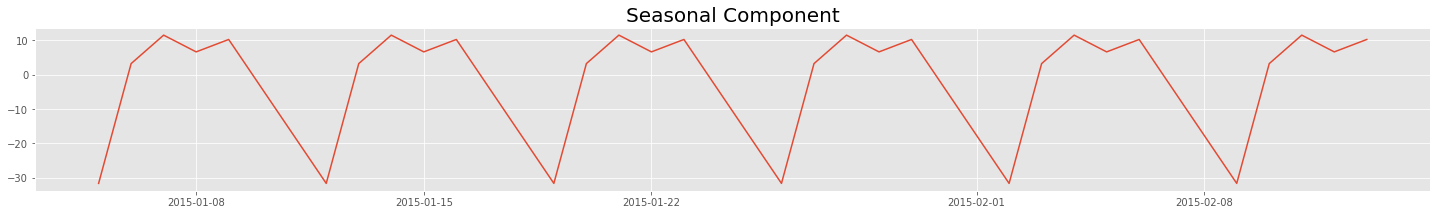

In [15]:
# Look at the seasonal part of the result
fig, ax = plt.subplots(1, 1, figsize=(25, 3))
plt.plot(df.index.tolist()[:30], result.seasonal[:30])
plt.title("Seasonal Component", fontsize=20);

Looking at the plot above, we can say there's a very strong seasonality aspect in the data over a given week. This is to be expected since we know the markets are closed every weekend and there's a weekly seasonality inherent to these index values.

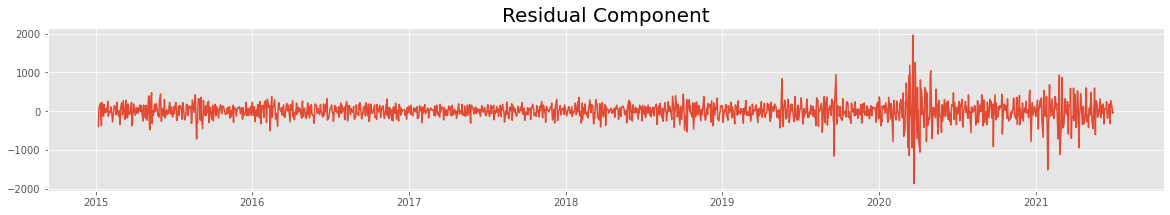

In [16]:
# Look at the residual part of the result
fig, ax = plt.subplots(1, 1, figsize=(20, 3))
plt.plot(df.index.tolist(), result.resid)
plt.title("Residual Component", fontsize=20);

From the residual component part, we can see there are several events which are very interesting.

- In the second half of 2015, there was a noticable dip which could be attributed to fears over slowdown in China.
- In the late 2019, COVID originated in China and there was a substantial movement in the index then.
- In mid-2020, COVID hit India adversely at it's worst and the residual in the index reflects that motion very visibly.
- In the early half of 2021, subsequent waves of COVID hit India adversely leading to a high unpredictability in the market index.

Now that we have some knowledge about the index movement, let us preprocess the dataset (i.e. handle categorical variables) so that we can build a `SARIMAX` model out of it.

We can handle these variables by using OneHotEncoder from sklearn or the get_dummies function from pandas.

In [17]:
from sklearn.preprocessing import OneHotEncoder

# Use the OneHotEncoder from sklearn, drop the first level in any given category
# This is to ensure no multicollinearity/redundancy in the column-space
OHE = OneHotEncoder(handle_unknown="ignore", drop="first")
cat_cols = ["DOW", "MOY", "Q"]
OHE.fit(df[cat_cols])
df_categorical = pd.DataFrame(
    OHE.transform(df[cat_cols]).toarray(),
    columns=OHE.get_feature_names_out(),
    index=df.index,
)
df_categorical.head(2)

,DOW_Monday,DOW_Thursday,DOW_Tuesday,DOW_Wednesday,MOY_August,MOY_December,MOY_February,MOY_January,MOY_July,MOY_June,MOY_March,MOY_May,MOY_November,MOY_October,MOY_September,Q_2,Q_3,Q_4
2015-01-05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-06,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
final_df = pd.concat([df, df_categorical], axis=1)
final_df.drop(columns=["DOW", "MOY", "Q", "Date"], inplace=True)
final_df.head(3)

,Close*,Holiday,DOW_Monday,DOW_Thursday,DOW_Tuesday,DOW_Wednesday,MOY_August,MOY_December,MOY_February,MOY_January,MOY_July,MOY_June,MOY_March,MOY_May,MOY_November,MOY_October,MOY_September,Q_2,Q_3,Q_4
2015-01-05,27842.32,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-06,26987.46,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-07,26908.82,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create an auto-arima model and figure out the AR, D, MA, Seasonal components and then fit a model.

In [19]:
from pmdarima import auto_arima
auto_arima(final_df["Close*"], seasonal=True, m=5).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1695
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 5)   Log Likelihood              -12414.701
Date:                             Sun, 14 Aug 2022   AIC                          24847.402
Time:                                     10:08:37   BIC                          24896.315
Sample:                                          0   HQIC                         24865.513
                                            - 1695                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     13.0776      9.267      1.411      0.158      -5.085      31.240
ar.L1         -1.6155      0.049    -33.286      0.000      -1.711      -1.520
ar.L2         -0.8256      0.058    -14.117      0.000      -0.940      -0.711
ar.L3          0.0415      0.017      2.481      0.013       0.009       0.074
ma.L1          1.6086      0.045     35.420      0.000       1.520       1.698
ma.L2          0.8471      0.046     18.462      0.000       0.757       0.937
ar.S.L5        0.8393      0.057     14.597      0.000       0.727       0.952
ma.S.L5       -0.7868      0.067    -11.734      0.000      -0.918      -0.655
sigma2      1.377e+05   2052.762     67.074      0.000    1.34e+05    1.42e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):             12335.77
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               4.59   Skew:                            -0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
train = final_df[final_df.index <= "2021-03-31"]
test = final_df[final_df.index > "2021-03-31"]

Now that we're aware of the components of the SARIMAX, we can build the model by splitting our original dataset into train and test sets

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train["Close*"],
    exog=train.drop(columns=["Close*"]),
    order=(3, 1, 2),
    seasonal_order=(1, 0, 1, 5),
    enforce_invertibility=False,
)
results = model.fit()
results.summary()

/home/vinayak/anaconda3/envs/paddy/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.79011D+00    |proj g|=  1.40661D-01

At iterate    5    f=  7.47609D+00    |proj g|=  2.70027D-01

At iterate   10    f=  7.34879D+00    |proj g|=  3.51515D-01

At iterate   15    f=  7.31703D+00    |proj g|=  2.69850D-02

At iterate   20    f=  7.31408D+00    |proj g|=  4.60306D-02

At iterate   25    f=  7.31185D+00    |proj g|=  3.42183D-02

At iterate   30    f=  7.31178D+00    |proj g|=  7.09560D-03

At iterate   35    f=  7.31176D+00    |proj g|=  2.93513D-03

At iterate   40    f=  7.31176D+00    |proj g|=  5.82763D-04

At iterate   45    f=  7.31172D+00    |proj g|=  2.02698D-02

At iterate   50    f=  7.31157D+00    |proj g|=  2.93608D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/vinayak/anaconda3/envs/paddy/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              Close*   No. Observations:                 1628
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 5)   Log Likelihood              -11903.229
Date:                             Sun, 14 Aug 2022   AIC                          23860.458
Time:                                     10:08:45   BIC                          24006.109
Sample:                                 01-05-2015   HQIC                         23914.497
                                      - 03-31-2021                                         
Covariance Type:                               opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Holiday          12.0682     33.354      0.362      0.717     -53.305      77.441
DOW_Monday      -40.9786     23.567     -1.739      0.082     -87.168       5.211
DOW_Thursday     -5.4460     25.405     -0.214      0.830     -55.238      44.346
DOW_Tuesday      -5.3704     30.558     -0.176      0.860     -65.263      54.522
DOW_Wednesday     5.3766     30.308      0.177      0.859     -54.026      64.780
MOY_August      -16.3788    125.238     -0.131      0.896    -261.840     229.083
MOY_December    -65.0231    182.606     -0.356      0.722    -422.924     292.878
MOY_February    -19.1119    124.858     -0.153      0.878    -263.830     225.606
MOY_January    -249.4639    131.815     -1.893      0.058    -507.817       8.890
MOY_July        248.1086    158.078      1.570      0.117     -61.718     557.936
MOY_June         36.9706    453.139      0.082      0.935    -851.166     925.107
MOY_March       188.3345    134.887      1.396      0.163     -76.040     452.709
MOY_May        -124.7517    451.110     -0.277      0.782   -1008.911     759.408
MOY_November     -8.3805    160.556     -0.052      0.958    -323.064     306.303
MOY_October       7.6593    208.724      0.037      0.971    -401.433     416.751
MOY_September  -191.8520    145.070     -1.322      0.186    -476.185      92.481
Q_2             106.1078    147.244      0.721      0.471    -182.484     394.700
Q_3              39.8778    245.684      0.162      0.871    -441.654     521.410
Q_4             -65.7443    197.266     -0.333      0.739    -452.378     320.889
ar.L1             1.3187      0.018     72.087      0.000       1.283       1.355
ar.L2            -0.9323      0.024    -39.101      0.000      -0.979      -0.886
ar.L3            -0.0308      0.015     -2.059      0.039      -0.060      -0.001
ma.L1            -1.3668      0.013   -107.066      0.000      -1.392      -1.342
ma.L2             1.0236      0.013     79.908      0.000       0.998       1.049
ar.S.L5           0.5517      0.110      4.999      0.000       0.335       0.768
ma.S.L5          -0.4456      0.120     -3.702      0.000      -0.682      -0.210
sigma2         1.327e+05   4013.355     33.058      0.000    1.25e+05    1.41e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):             12259.19
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               4.43   Skew:                            -0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condit

In [22]:
# Obtain predicted values
start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(
    start=start, end=end, exog=test.drop(columns=["Close*"]), index=test.index
).rename("Predicted Close*")

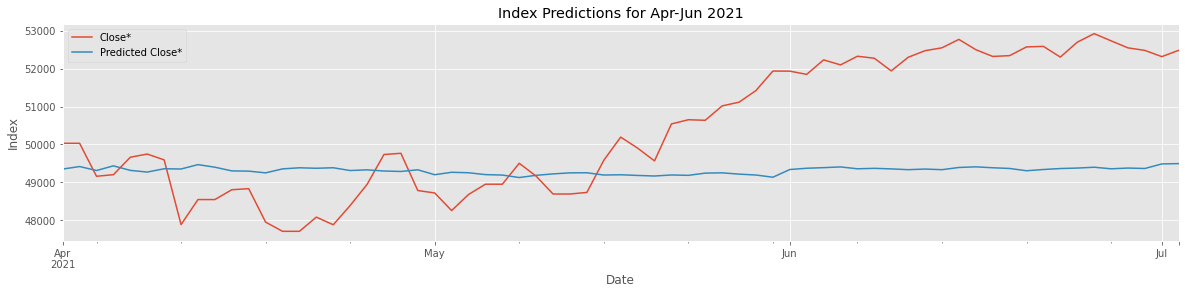

In [23]:
# Plot predictions against known values
title = "Index Predictions for Apr-Jun 2021"
ylabel = "Index"
xlabel = "Date"

ax = test["Close*"].plot(legend=True, figsize=(20, 4), title=title)
predictions.plot(legend=True)
ax.autoscale(axis="x", tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [24]:
# Check the RMSE on train and test sets

train_preds = results.predict(
    start=0, end=len(train) - 1, exog=train.drop(columns=["Close*"]), index=train.index
).rename("Predicted Close*")

train_rmse = ((train_preds - train["Close*"]) ** 2).sum() ** 0.5
test_rmse = ((predictions - test["Close*"]) ** 2).sum() ** 0.5

print(f"Train RMSE: {train_rmse:.3f}\t Test RMSE: {test_rmse:.3f}")
print(f'Train Mean: {train["Close*"].mean():.3f}\t Test Mean: {test["Close*"].mean():.3f}')
print(f'Train Std: {train["Close*"].std():.3f}\t Test Std: {test["Close*"].std():.3f}')

Train RMSE: 31729.069	 Test RMSE: 16421.396
Train Mean: 33394.682	 Test Mean: 50409.678
Train Std: 6240.923	 Test Std: 1715.854


# Deep Learning Based Prediction Methods

**Multi-step CNN Model**

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.modules import *

In [26]:
cnn_df = deepcopy(df)
cnn_df.drop(columns = ["Date"], inplace = True)

In [27]:
cnn_df["Close*"] = (cnn_df["Close*"] - cnn_df["Close*"].mean())/ cnn_df["Close*"].std() 

In [28]:
dow = df.DOW.unique().tolist()
moy = df.MOY.unique().tolist()
qtr = df.Q.unique().tolist()

In [29]:
cnn_df["DOW"] = cnn_df.DOW.apply(lambda x: dow.index(x))
cnn_df["MOY"] = cnn_df.MOY.apply(lambda x: moy.index(x))
cnn_df["Q"] = cnn_df.Q.apply(lambda x: qtr.index(x))

In [101]:
import numpy as np
class sequenceGenerator(Dataset):
    def __init__(self, df, pred_col:str = "Close*", input_steps:int = 100, output_steps:int = 64):
        self.df = df
        self.input_steps = 100
        self.pred_col = pred_col
        self.output_steps = 64
    
    def __getitem__(self, idx):
        start = idx
        mid = idx + self.input_steps - 1
        end = mid + self.output_steps - 1
        
        seq_ip = self.df.loc[start:mid, self.pred_col].values
        seq_ip = np.expand_dims(seq_ip, 0)
        exogenous_ip = self.df.loc[mid:end].drop(columns = [self.pred_col]).values
        op = self.df.loc[mid:end, self.pred_col].values
        return (seq_ip.astype(np.float32), exogenous_ip.astype(np.float32), op.astype(np.float32))
    
    def __len__(self,):
        return len(self.df) - self.output_steps - self.input_steps

In [107]:
dset = sequenceGenerator(cnn_df.reset_index(drop = True))
dls = DataLoader(dset, num_workers = 0, batch_size = 10)

In [108]:
class customNet(nn.Module):
    
    def __init__(self, n_exogenous = 2, individual_exogenous_hidden_neurons = 1):
        super().__init__()
        self.conv1 = Conv1d(1, 100, 3, padding = "same")
        self.bn1 = BatchNorm1d(100)
        self.conv2 = Conv1d(100, 64, 3, padding = "same")
        
        self.f1 = Linear(4, 10)
        self.bn2 = BatchNorm1d(10)
        self.f2 = Linear(10, 1)
        self.bn3 = BatchNorm1d(64)
        
        self.final_layer = Linear(64, 64) 
        
    def forward(self, x_seq, x_exogenous):
        # Get the convolutional features
        conv_features = self.conv2(F.relu(self.bn1(self.conv1(x_seq)))).mean(-1)
        individual_outputs = []
        
        
        # Get the features coming out of the exogeneous features
        for i in range(x_exogenous.shape[1]):
            activation = self.f2(F.relu(self.bn2(self.f1(x_exogenous[:,i,:]))))
            individual_outputs.append(activation)
        fv = torch.cat(individual_outputs, dim = 1)
        
        # Convolution + Exogeneous features output
        convogenous_features = fv + conv_features
        
        
        return self.final_layer(F.relu(self.bn3(convogenous_features)))

In [109]:
net = customNet()

In [110]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr = 5e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-3, steps_per_epoch=len(dls), epochs=20)

In [111]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    rmspe = 0.0
    for i, data in enumerate(dls, 0):
        # get the inputs; data is a list of [inputs, labels]
        seq_inps, exogeneous_feats, targets = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(seq_inps, exogeneous_feats)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # print statistics
        running_loss += loss.item()
        
        with torch.no_grad():
            rmspe = (rmspe * i + ((targets - outputs / targets)**2).sum().mean() ** 0.5) / (i + 1)
        
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {rmspe:.3f}')
        running_loss = 0.0

print('Finished Training')

[1,     1] loss: 25.967
[1,     2] loss: 26.269
[1,     3] loss: 26.648
[1,     4] loss: 27.022
[1,     5] loss: 27.332
[1,     6] loss: 27.606
[1,     7] loss: 27.928
[1,     8] loss: 28.192
[1,     9] loss: 28.405
[1,    10] loss: 28.592
[1,    11] loss: 28.813
[1,    12] loss: 29.107
[1,    13] loss: 29.436
[1,    14] loss: 29.812
[1,    15] loss: 30.189
[1,    16] loss: 30.547
[1,    17] loss: 30.874
[1,    18] loss: 31.149
[1,    19] loss: 31.362
[1,    20] loss: 31.508
[1,    21] loss: 31.577
[1,    22] loss: 31.593
[1,    23] loss: 31.576
[1,    24] loss: 31.516
[1,    25] loss: 31.425
[1,    26] loss: 31.296
[1,    27] loss: 31.139
[1,    28] loss: 30.965
[1,    29] loss: 30.777
[1,    30] loss: 30.584
[1,    31] loss: 30.403
[1,    32] loss: 30.239
[1,    33] loss: 30.097
[1,    34] loss: 29.993
[1,    35] loss: 29.917
[1,    36] loss: 29.874
[1,    37] loss: 29.845
[1,    38] loss: 29.827
[1,    39] loss: 29.803
[1,    40] loss: 29.764
[1,    41] loss: 29.701
[1,    42] loss:

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 10])

In [ ]:
cnn_df.iloc[1535:, :]

In [ ]:
x_seq = torch.randn(20, 1, 100)
x_exogenous = torch.randn(20, 64, 5)

In [ ]:
cn(x_seq, x_exogenous)

In [ ]:
import torch.nn as nn
from torch.nn.modules import *

In [ ]:
c = Conv1d(1, 5, (3), padding="same")

In [ ]:
(c(torch.randn(20, 1, 10))).mean(-1).shape

In [ ]:
a

In [ ]:
c

In [ ]:
b